# IBM Python for Data Science Capstone Project: Analysis of the Gun Industry in the US

## Benjamin Schloss


This notebook is dedicated to my final project for the Capstone Course of IBM's Python for Data Science Specialization. 

Introduction

	As the Democratic primary in the US heats up, one of the central topics on Americans minds come election time will be gun control. Beto O’ Rourke drew plaudits amongst many liberal pundits, and uproar from conservatives, when he proudly stated in a debate that “We are going to take your guns!” However, despite this big talk from similarly minded Democrat politicians, the numbers tell a different story. In fact, even in most states that have been held by Democrats for years, gun purchases have been increasing per capita for decades.
	
	In this project, I will analyze the complex dichotomy between the political movement in the United States to increase restrictions on gun sales and the stark reality that gun sales have been increasing in almost every state for years. Through this analysis, I hope to first to shed light on the political and social realities surrounding the issue of gun control in the US, before shifting to a business-minded perspective. Given my findings and the current sociopolitical climate, should investors in gun manufacturers be concerned about their money if Democrats take the White House and Senate? And if the gun industry is indeed still growing despite the current societal divide over the issue of gun control, where are most gun shops located, and where can we expect to see more stores grow in the future?

Data

	The FBI’s National Instant Criminal Background Check (NICS) database has data on state background checks for purchased guns spanning decades. I extracted this data for the last 5 years (2015-2019) for the 49 mainland states of the US (Hawaii was excluded due to inconsistent data). It is important to note that this data cannot be used as an exact count of gun sales because many individuals (possibly 40% of gun purchasers) purchase their firearms privately, meaning they do not go through a licensed store that will run a background check. A special thanks to Buzzfeed New’s Github repository on the topic!
	I then compared the number of background checks in each state per year to Gifford’s Law Center’s Annual Gun Law Rankings, a pro-gun restriction lobbying group in Washington DC. Finally, I examined the number of gun shops in the vicinity of the 30 most populous cities in the United States using API FourSquare data.
    
Methodology

    After importing the data, I made sure to convert the categorical letter grades from Gifford's to quantitative number grades in order to allow easier correlational analysis. Additionally, because US states have widely varying overall populations, it was important to calculate the background checks made per capita, and run the correlation between this and Gifford's gun law grades. Thus, I now have controlled the influence of population size when determining the answer to the main question of this project: do stricter gun laws reduce gun purchases?
    Additionally, it logically makes sense that states with stricter gun laws should generally sell less guns per person than states with looser gun laws. States with populations more willing to accept stricter gun laws may perhaps be more anti-gun to begin with. So to further examine this issue, I also isolated every case where a state increased their gun laws in meaningful enough ways to raise their gun scorecard grade with Gifford's, and analyzed the relationship between these changes the changes in gun background checks that resulted.
    
Results

    As expected, there was a moderate negative relationship between stricter gun laws and background checks per capita in the US between 2015 and 2019 (r = -0.586, p = >.001). The significance of this relationship confirms the claim that there are typically less gun sales in states with stricter gun laws than states with looser gun laws. However, it does not answer whether that relationship is due to the laws themselves, or due to the underlying culture of the state. In fact, there was no statistically significant relationship between increasing gun law stringency and change in background checks per capita (r = -0.186, P = 0.341). This suggests that perhaps culture plays a more important role in gun sales than laws themselves.
    I then used FourSquare API to find all gun shops within a 30 mile radius of the city center of each of the US's 30 most populous cities in order to determine what regions of the country the gun industry appears to be booming. After running k-means clustering on my results, I found 4 distinct regions in the US in terms of gun sales. The US southwest has the the cities with the most gun shops, with Denver, Phoenix, Las Vegas, and Fort Worth all having 40 or more gun shops. The cluster on the east coast tended to have the least amount of gun shops, while the west coast and southern cluster tended to have moderate amounts of gun stores.

In [367]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pylab as plt

import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium

from sklearn.cluster import KMeans

print('Hello Capstone Project Course!')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Hello Capstone Project Course!


In [368]:
#Step 1: Import Tables of Gun Data by state per year.

headers = ['month', 'state', 'permit', 'permit_recheck', 'handgun', 'long_gun', 'other', 'multiple', 'admin', 'prepawn_handgun', 'prepawn_long_gun', 'prepawn_other', 'redemption_handgun', 'redemption_long_gun', 'redemption_other', 'returned_handgun', 'returned_long_gun', 'returned_other', 'rentals_handgun', 'rentals_long_gun', 'private_sale_handgun', 'private_sale_long_gun', 'private_sale_other', 'return_to_seller_handgun', 'return_to_seller_long_gun', 'return_to_seller_other', 'totals']
df = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/nics-firearm-background-checks/master/data/nics-firearm-background-checks.csv', names = headers, nrows = 3356)

In [369]:
df = df.drop(labels = 0)

In [370]:
df.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,redemption_handgun,redemption_long_gun,redemption_other,returned_handgun,returned_long_gun,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
1,2020-01,Alabama,37140,510,22478,12598,1313,1010,0,43,17,5,2706,1417,16,0,0,0,0,0,43,31,3,1,1,0,79332
2,2020-01,Alaska,223,7,2151,1529,312,142,0,1,1,0,140,95,2,48,40,0,0,0,3,8,4,0,0,0,4706
3,2020-01,Arizona,5727,808,15126,7087,1475,1022,0,12,4,1,1300,521,5,99,8,1,0,0,16,10,2,0,0,0,33224
4,2020-01,Arkansas,3094,790,6621,5524,435,368,8,14,3,0,1072,1153,1,0,0,0,0,0,27,12,1,1,1,1,19126
5,2020-01,California,34694,0,34884,22057,4131,0,0,0,0,0,451,338,12,0,0,0,0,0,0,0,0,0,0,0,96567


In [372]:
df_gun = df[['month','state','handgun','long_gun','multiple']]
df_gun['handgun'] = df_gun['handgun'].astype(int)
df_gun['long_gun'] = df_gun['long_gun'].astype(int)
df_gun['multiple'] = df_gun['multiple'].astype(int)
df_gun = df_gun.loc[56:3355]
df_gun = df_gun.reset_index().drop('index', axis=1, inplace=False)
df_gun['total'] = df_gun.sum(axis=1)
df_gun.head()

/Users/Ben/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Ben/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Ben/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,month,state,handgun,long_gun,multiple,total
0,2019-12,Alabama,33020,25882,1382,60284
1,2019-12,Alaska,3455,3080,215,6750
2,2019-12,Arizona,18178,10423,1109,29710
3,2019-12,Arkansas,8671,10957,458,20086
4,2019-12,California,40637,30780,0,71417


In [373]:
df_gun = df_gun.drop(df_gun.index[df_gun['state'] == 'Guam'])
df_gun = df_gun.drop(df_gun.index[df_gun['state'] == 'Hawaii'])
df_gun = df_gun.drop(df_gun.index[df_gun['state'] == 'Mariana Islands'])
df_gun = df_gun.drop(df_gun.index[df_gun['state'] == 'Puerto Rico'])
df_gun = df_gun.drop(df_gun.index[df_gun['state'] == 'Virgin Islands'])
df_gun = df_gun.drop(df_gun.index[df_gun['state'] == 'District of Columbia'])
df_gun.reset_index(inplace=True)
df_gun = df_gun.drop('index', axis = 1)
df_gun.head()

,month,state,handgun,long_gun,multiple,total
0,2019-12,Alabama,33020,25882,1382,60284
1,2019-12,Alaska,3455,3080,215,6750
2,2019-12,Arizona,18178,10423,1109,29710
3,2019-12,Arkansas,8671,10957,458,20086
4,2019-12,California,40637,30780,0,71417


In [374]:
df_2019 = df_gun.iloc[0:588]
df_2018 = df_gun.iloc[588:1176]
df_2017 = df_gun.iloc[1176:1764]
df_2016 = df_gun.iloc[1764:2352]
df_2015 = df_gun.iloc[2352:2940]
df_2019 = df_2019.groupby('state').sum()
df_2018 = df_2018.groupby('state').sum()
df_2017 = df_2017.groupby('state').sum()
df_2016 = df_2016.groupby('state').sum()
df_2015 = df_2015.groupby('state').sum()
df_2019['year'] = 2019
df_2019 = df_2019.reindex(columns = ['year','handgun','long_gun','multiple','total'])
df_2018['year'] = 2018
df_2018 = df_2018.reindex(columns = ['year','handgun','long_gun','multiple','total'])
df_2017['year'] = 2017
df_2017 = df_2017.reindex(columns = ['year','handgun','long_gun','multiple','total'])
df_2016['year'] = 2016
df_2016 = df_2016.reindex(columns = ['year','handgun','long_gun','multiple','total'])
df_2015['year'] = 2015
df_2015 = df_2015.reindex(columns = ['year','handgun','long_gun','multiple','total'])
df_2015

,year,handgun,long_gun,multiple,total
state,,,,,
Alabama,2015,243734,176075,10781,430590
Alaska,2015,37086,36372,2240,75698
Arizona,2015,148400,93155,6794,248349
Arkansas,2015,77394,83097,4248,164739
California,2015,477822,343127,0,820949
Colorado,2015,216791,163128,12415,392334
Connecticut,2015,123507,48350,0,171857
Delaware,2015,23245,20043,803,44091
Florida,2015,572020,277768,21369,871157


In [375]:
#Merge the dataframes for each year, groupby/sort by year/state OR evaluate next step and see whether I should just
# groupby state above and take the mean per year, so I 
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia',
         'Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Lousisiana','Maine','Maryland','Massachussetts',
         'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey'
         'New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island',
         'South Carolina','South Dakota','Tennessee', 'Texas','Utah','Vermont','Virginia','Washington','West Virginia',
         'Wisconsin','Wyoming']
grades_2019 = [0,0,0,0,4,2,4,3,2,0,0,4,1,2,0,0,0,0,4,4,2,2,0,0,0,2,2,0,4,2,4,1,0,1,0,2,2,3,0,0,1,0,1,2,1,3,0,2,0]
grades_2018 = [0,0,0,0,4,2,4,3,2,0,0,3,1,2,0,0,0,0,4,4,2,2,0,0,0,2,1,0,4,0,4,1,0,1,0,2,2,3,0,0,1,0,1,1,1,3,0,2,0]
grades_2017 = [0,0,0,0,4,2,4,3,0,0,0,2,1,2,0,0,0,0,4,4,2,2,0,0,0,1,1,0,4,0,4,1,0,1,0,2,2,4,0,0,1,0,0,0,1,3,0,2,0]
grades_2016 = [0,0,0,0,4,2,4,3,0,0,0,3,1,2,0,0,0,0,4,4,2,2,0,0,0,1,2,1,4,1,4,1,0,1,0,2,2,3,0,0,0,0,0,0,1,3,0,2,0]
grades_2015 = [0,0,0,0,4,2,4,3,0,0,0,3,1,2,0,0,0,0,4,4,2,2,0,0,0,1,0,1,4,0,4,0,0,1,0,2,2,3,0,0,0,0,0,0,1,3,1,1,0]

In [406]:
df_2019['grade'] = grades_2019
df_2018['grade'] = grades_2018
df_2017['grade'] = grades_2017
df_2016['grade'] = grades_2016
df_2015['grade'] = grades_2015
df_2 = pd.read_excel('/Users/Ben/Downloads/Book1.xlsx')
df_2.set_index('state')
pop_2019 = list(df_2[2019])
df_2019['population'] = pop_2019
pop_2018 = list(df_2[2018])
df_2018['population'] = pop_2018
pop_2017 = list(df_2[2017])
df_2017['population'] = pop_2017
pop_2016 = list(df_2[2016])
df_2016['population'] = pop_2016
pop_2015 = list(df_2[2015])
df_2015['population'] = pop_2015
df_total = pd.concat([df_2019, df_2018, df_2017, df_2016, df_2015])
df_total['per_capita'] = df_total['total']/df_total['population']
df_total.head(20)

,year,handgun,long_gun,multiple,total,grade,population,per_capita
state,,,,,,,,
Alabama,2019,160667,120258,7868,288793,0,4903185,0.059
Alaska,2019,31943,31090,2476,65509,0,731545,0.090
Arizona,2019,158864,89182,10361,258407,0,7278717,0.036
Arkansas,2019,68549,68773,4947,142269,0,3017804,0.047
California,2019,432239,299161,0,731400,4,39512223,0.019
Colorado,2019,210909,147663,13330,371902,2,5758736,0.065
Connecticut,2019,58808,22410,0,81218,4,3565287,0.023
Delaware,2019,20228,16949,993,38170,3,973764,0.039
Florida,2019,608924,225560,29538,864022,2,21477737,0.040


In [377]:
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
%matplotlib inline 

In [378]:
X = df_total['grade']
Y = df_total['per_capita']

pearson_coef, p_value = stats.pearsonr(X, Y)
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P = ", p_value)  

The Pearson Correlation Coefficient is -0.5864000835336758  with a P-value of P =  5.0332246300811554e-24


(0, 0.1082017811640372)

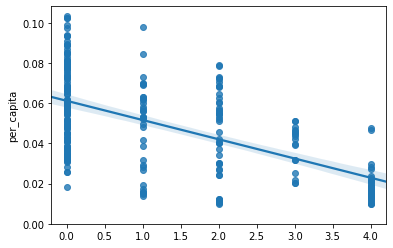

In [379]:
X = df_total[['grade']]
lm = LinearRegression()
lm.fit(X,Y)
Yhat=lm.predict(X)
sns.regplot(x=X, y=Y, data=df_total)
plt.ylim(0,)

In [380]:
df_group = df_total.groupby('state').mean()
X1 = df_group['grade']
Y1 = df_group['per_capita']
pearson_coef, p_value = stats.pearsonr(X1, Y1)
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P = ", p_value)  

The Pearson Correlation Coefficient is -0.6136707707674625  with a P-value of P =  2.748898201553568e-06


In [381]:
df_stricter = df_total.loc[['Florida', 'Illinois', 'Nebraska', 'Nevada', 'New Mexico', 'North Carolina', 'Rhode Island', 'Tennessee', 'Utah', 'Vermont', 'Wisconsin']]
df_stricter = df_stricter.reset_index()
df_stricter = df_stricter.iloc[[0,1,2,5,6,7,10,11,12,15,16,20,21,27,28,29,32,33,37,38,41,42,45,46,47,52,53,54]]
df_stricter['per_cap_change'] = [0,-.05,0,-.02,-.02,0,0,-.02,0,.01,0,.01,0,-.02,.01,0,-.03,0,-.08,0,-.03,0,-.09,.05,0,-.03,.07,0]
df_stricter['grade_change'] = [0,2,0,1,1,0,0,1,0,1,0,2,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0]
pearson_coef, p_value = stats.pearsonr(df_stricter['grade_change'], df_stricter['per_cap_change'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P = ", p_value)


The Pearson Correlation Coefficient is -0.18661575768802297  with a P-value of P =  0.3416829442335882


## Now, I will leverage API FourSquare data to compare gun the frequency of gun stores in cities across the United States

In [382]:
df_2 = pd.read_html('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population')
df_2 = df_2[4].set_index('2018rank')
df_2 = df_2.drop(['2010Census','Change','2016 land area', '2016 land area.1', '2016 population density', '2016 population density.1', 'Location'], axis = 1)
Latitude = [40.6635, 34.0194, 41.8376, 29.7866, 33.5722, 40.0094, 29.4724, 32.8153, 32.7933, 37.2967, 30.3039,
            30.3369, 32.7815, 39.9852, 37.7272, 35.2078, 39.7767, 47.6205, 39.7619, 38.9041, 42.3320, 31.8484,
            42.3830, 36.1718, 45.5370, 35.1028, 35.4671, 36.2292, 38.1654, 39.3000]
Longitude = [-73.9387, -118.4108, -87.6818, -95.3909, -112.0901, -75.1333, -98.5251, -117.1350, -96.7665, -121.8189, -97.7544,
            -81.6616, -97.3467, -82.9848, -123.0322, -80.8310, -86.1459, -122.3509, -104.8811, -77.0172, -71.0202, -106.4270,
            -83.1022, -86.7850, -122.6500, -89.9774, -97.5137, -115.2601, -85.6474, -76.6105]
df_2 = df_2[0:30]
df_2['Latitude'] = Latitude
df_2['Longitude'] = Longitude
df_2

,City,State[c],2018estimate,Latitude,Longitude
2018rank,,,,,
1,New York[d],New York,8398748,40.663,-73.939
2,Los Angeles,California,3990456,34.019,-118.411
3,Chicago,Illinois,2705994,41.838,-87.682
4,Houston[3],Texas,2325502,29.787,-95.391
5,Phoenix,Arizona,1660272,33.572,-112.090
6,Philadelphia[e],Pennsylvania,1584138,40.009,-75.133
7,San Antonio,Texas,1532233,29.472,-98.525
8,San Diego,California,1425976,32.815,-117.135
9,Dallas,Texas,1345047,32.793,-96.766


In [383]:
#Step 4: Take 30 biggest US cities. Find estimated percent gun shops 

CLIENT_ID = '2E3HE34ZZO3QIDOW4MKQKDRGFO30NV1AGQE5OBY4ZUABRMRE'
CLIENT_SECRET = 'IJKYWZKEETG2ISNIGVRPNU13XX3K2FHCBGVU3V3Y1O0PB1XG'
VERSION = '20180604'
QUERY = 'Gun Shop'

In [384]:
LIMIT = 1000
def check_venues(names, latitudes, longitudes, radius=30000):
    
    venues_list = []
    for name, lat, long in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat,
            long,
            radius,
            LIMIT,
            QUERY)
    
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            long, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [388]:
gun_shops = check_venues(names=df_2['City'], latitudes=df_2['Latitude'], longitudes=df_2['Longitude'])
gun_shops.head()

New York[d]
Los Angeles
Chicago
Houston[3]
Phoenix
Philadelphia[e]
San Antonio
San Diego
Dallas
San Jose
Austin
Jacksonville[f]
Fort Worth
Columbus
San Francisco[g]
Charlotte
Indianapolis[h]
Seattle
Denver[i]
Washington[j]
Boston
El Paso
Detroit
Nashville[k]
Portland
Memphis
Oklahoma City
Las Vegas
Louisville[l]
Baltimore[m]


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York[d],40.663,-73.939,Seneca Sporting Range,40.699,-73.903,Gun Shop
1,New York[d],40.663,-73.939,Mitchell Custom Guns & Bulletworks LLC,40.724,-73.998,Gun Shop
2,New York[d],40.663,-73.939,Collections of Professions,40.742,-73.989,Gun Shop
3,New York[d],40.663,-73.939,Pistol License Specialists,40.744,-73.987,Gun Shop
4,New York[d],40.663,-73.939,Caso's Gun-A-Rama,40.698,-74.092,Gun Shop


In [389]:
gun_shops = gun_shops.drop(gun_shops.index[gun_shops['Venue Category'] != 'Gun Shop'])
gun_shops.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York[d],40.663,-73.939,Seneca Sporting Range,40.699,-73.903,Gun Shop
1,New York[d],40.663,-73.939,Mitchell Custom Guns & Bulletworks LLC,40.724,-73.998,Gun Shop
2,New York[d],40.663,-73.939,Collections of Professions,40.742,-73.989,Gun Shop
3,New York[d],40.663,-73.939,Pistol License Specialists,40.744,-73.987,Gun Shop
4,New York[d],40.663,-73.939,Caso's Gun-A-Rama,40.698,-74.092,Gun Shop


In [390]:
gun_group = gun_shops.groupby('City').count()
gun_group2 = gun_group.sort_values('Venue', ascending = False)
gun_group

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Austin,16,16,16,16,16,16
Baltimore[m],10,10,10,10,10,10
Boston,13,13,13,13,13,13
Charlotte,5,5,5,5,5,5
Chicago,11,11,11,11,11,11
Columbus,14,14,14,14,14,14
Dallas,21,21,21,21,21,21
Denver[i],41,41,41,41,41,41
Detroit,15,15,15,15,15,15


In [391]:
df_2 = df_2.sort_values('City', ascending= True)
count = [16,10,13,5,11,14,21,41,15,5,40,27,18,13,40,24,6,9,8,8,14,11,41,19,22,20,0,8,16,12]
df_2['Gun_Shop_Count'] = count
df_2

,City,State[c],2018estimate,Latitude,Longitude,Gun_Shop_Count
2018rank,,,,,,
11,Austin,Texas,964254,30.304,-97.754,16
30,Baltimore[m],Maryland,602495,39.300,-76.611,10
21,Boston,Massachusetts,694583,42.332,-71.020,13
16,Charlotte,North Carolina,872498,35.208,-80.831,5
3,Chicago,Illinois,2705994,41.838,-87.682,11
14,Columbus,Ohio,892533,39.985,-82.985,14
9,Dallas,Texas,1345047,32.793,-96.766,21
19,Denver[i],Colorado,716492,39.762,-104.881,41
23,Detroit,Michigan,672662,42.383,-83.102,15


In [342]:
kclusters = 4

US_gun = df_2.drop(['City', 'State[c]', '2018estimate'], axis=1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(US_gun)

kmeans.labels_[0:10] 

array([3, 0, 0, 0, 0, 0, 3, 2, 0, 3], dtype=int32)

In [344]:
#df_2.insert(0,'Cluster Labels', kmeans.labels_)
df_2.head()

,Cluster Labels,City,State[c],2018estimate,Latitude,Longitude,Gun_Shop_Count
2018rank,,,,,,,
11,0,Austin,Texas,964254,30.304,-97.754,16
30,3,Baltimore[m],Maryland,602495,39.300,-76.611,10
21,3,Boston,Massachusetts,694583,42.332,-71.020,13
16,3,Charlotte,North Carolina,872498,35.208,-80.831,5
3,3,Chicago,Illinois,2705994,41.838,-87.682,11


In [340]:
import matplotlib.cm as cm
import matplotlib.colors as colors


In [360]:
latitude = 37.0902
longitude = -95.7129
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4.1)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(df_2['Latitude'], df_2['Longitude'], df_2['City'], df_2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow, #[cluster-1]
        fill=True,
        fill_color=rainbow, #[cluster-1]
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [355]:
df_2.loc[df_2['Cluster Labels'] == 0, df_2.columns[list(range(0, df_2.shape[1]))]]

,Cluster Labels,City,State[c],2018estimate,Latitude,Longitude,Gun_Shop_Count
2018rank,,,,,,,
11,0,Austin,Texas,964254,30.304,-97.754,16
9,0,Dallas,Texas,1345047,32.793,-96.766,21
22,0,El Paso,Texas,682669,31.848,-106.427,5
4,0,Houston[3],Texas,2325502,29.787,-95.391,27
27,0,Oklahoma City,Oklahoma,649021,35.467,-97.514,14
7,0,San Antonio,Texas,1532233,29.472,-98.525,22


In [356]:
df_2.loc[df_2['Cluster Labels'] == 1, df_2.columns[list(range(0, df_2.shape[1]))]]

,Cluster Labels,City,State[c],2018estimate,Latitude,Longitude,Gun_Shop_Count
2018rank,,,,,,,
2,1,Los Angeles,California,3990456,34.019,-118.411,24
25,1,Portland,Oregon,653115,45.537,-122.650,19
8,1,San Diego,California,1425976,32.815,-117.135,20
15,1,San Francisco[g],California,883305,37.727,-123.032,0
10,1,San Jose,California,1030119,37.297,-121.819,8
18,1,Seattle,Washington,744955,47.620,-122.351,16


In [357]:
df_2.loc[df_2['Cluster Labels'] == 2, df_2.columns[list(range(0, df_2.shape[1]))]]

,Cluster Labels,City,State[c],2018estimate,Latitude,Longitude,Gun_Shop_Count
2018rank,,,,,,,
19,2,Denver[i],Colorado,716492,39.762,-104.881,41
13,2,Fort Worth,Texas,895008,32.782,-97.347,40
28,2,Las Vegas,Nevada,644644,36.229,-115.260,40
5,2,Phoenix,Arizona,1660272,33.572,-112.090,41


In [358]:
df_2.loc[df_2['Cluster Labels'] == 3, df_2.columns[list(range(0, df_2.shape[1]))]]

,Cluster Labels,City,State[c],2018estimate,Latitude,Longitude,Gun_Shop_Count
2018rank,,,,,,,
30,3,Baltimore[m],Maryland,602495,39.300,-76.611,10
21,3,Boston,Massachusetts,694583,42.332,-71.020,13
16,3,Charlotte,North Carolina,872498,35.208,-80.831,5
3,3,Chicago,Illinois,2705994,41.838,-87.682,11
14,3,Columbus,Ohio,892533,39.985,-82.985,14
23,3,Detroit,Michigan,672662,42.383,-83.102,15
17,3,Indianapolis[h],Indiana,867125,39.777,-86.146,18
12,3,Jacksonville[f],Florida,903889,30.337,-81.662,13
29,3,Louisville[l],Kentucky,620118,38.165,-85.647,6


In [392]:
df_denver = gun_shops.iloc[338:379]
df_denver.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
361,Denver[i],39.762,-104.881,New Sparta Combat Sports,39.610,-105.036,Gun Shop
362,Denver[i],39.762,-104.881,Westminster Arms,39.819,-105.082,Gun Shop
363,Denver[i],39.762,-104.881,The Reloaders Corner,39.814,-105.130,Gun Shop
364,Denver[i],39.762,-104.881,Bristlecone Shooting Training & Retail Center,39.713,-105.136,Gun Shop
365,Denver[i],39.762,-104.881,Eagles Nest Armory,39.814,-105.137,Gun Shop


In [400]:
latitude = 39.762
longitude = -104.881
denver_map = folium.Map(location=[latitude, longitude], zoom_start=10)
denver_map

In [405]:
# instantiate a feature group for the incidents in the dataframe
guns = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(df_denver['Venue Latitude'], df_denver['Venue Longitude']):
    guns.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(df_denver['Venue Latitude'])
longitudes = list(df_denver['Venue Longitude'])
labels = list(df_denver['Venue'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(denver_map)    
    
# add incidents to map
denver_map.add_child(guns)